In [6]:
import os
folder_path = '/kaggle/input/realwaste/realwaste-main/RealWaste'
os.chdir(folder_path)
print("Contents:", os.listdir(folder_path))

Contents: ['Metal', 'Glass', 'Paper', 'Vegetation', 'Cardboard', 'Textile Trash', 'Food Organics', 'Plastic', 'Miscellaneous Trash']


In [7]:
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, SubsetRandomSampler
import time
import random
from torch.optim.lr_scheduler import ReduceLROnPlateau

transform = transforms.Compose([transforms.Resize((224, 224)), 
                                transforms.RandomHorizontalFlip(), 
                                transforms.RandomRotation((0, 180)), 
                                transforms.ToTensor(), 
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
dataset = datasets.ImageFolder(root=folder_path, transform = transform)
dataset_size = len(dataset)

indices = list(range(dataset_size))
random.seed(42)
random.shuffle(indices)

test_split = int(0.1 * dataset_size)
val_split = int(0.1 * dataset_size)


test_indices = indices[:test_split]
val_indices = indices[test_split:test_split + val_split]
train_indices = indices[test_split + val_split:]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = DataLoader(dataset, batch_size=128, sampler=train_sampler, num_workers=4, pin_memory=True)
val_loader = DataLoader(dataset, batch_size=128, sampler=val_sampler)
test_loader = DataLoader(dataset, batch_size=128, sampler=test_sampler, num_workers=4, pin_memory=True)

In [8]:
import torch.nn as nn
import torch.optim as optim
from collections import Counter

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.resnet18(pretrained=True)

num_classes = len(dataset.classes)
# model.fc = model.fc = nn.Linear(model.fc.in_features, num_classes)
model.fc = nn.Sequential(nn.Dropout(0.5), nn.Linear(model.fc.in_features, num_classes))

model = model.to(device)

class_counts = Counter([label for _, label in dataset.samples])
class_counts_values = torch.tensor(list(class_counts.values()), dtype=torch.float)
class_weights = 1.0 / class_counts_values
class_weights = class_weights / class_weights.sum()

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 138MB/s] 
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn

In [9]:
for images, labels in val_loader:
    print(f"Sample Validation Labels: {labels[:10].tolist()}")
    break

#val_labels = [label for _, label in dataset.samples if _ in val_sampler.indices]
val_labels = [dataset.samples[i][1] for i in val_sampler.indices]
from collections import Counter
val_class_counts = Counter(val_labels)
print(f"Validation Class Distribution: {val_class_counts}")

Sample Validation Labels: [3, 6, 5, 4, 6, 1, 1, 3, 3, 4]
Validation Class Distribution: Counter({6: 86, 3: 75, 4: 52, 5: 52, 8: 47, 0: 47, 2: 42, 7: 38, 1: 36})


In [10]:
num_epochs = 20

for epoch in range(num_epochs):
    print(f"Starting epoch {epoch + 1}/{num_epochs}...")  # Debug point 1

    model.train()
    train_loss = 0.0
    train_correct = 0

    for batch_idx, (images, labels) in enumerate(train_loader):
    # print(f"Processing batch {batch_idx + 1}/{len(train_loader)}")  # Debug point 2

      images, labels = images.to(device), labels.to(device)

      optimizer.zero_grad()
      outputs = model(images)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      train_loss += loss.item() * images.size(0)
      train_correct += (outputs.argmax(dim=1) == labels).sum().item()

    train_loss /= len(train_sampler.indices)
    train_acc = train_correct / len(train_sampler.indices)

    model.eval()
    val_loss = 0.0
    val_correct = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            val_correct += (outputs.argmax(dim = 1) == labels).sum().item()

    val_loss /= len(val_sampler.indices)
    val_acc = val_correct / len(val_sampler.indices)


    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")
    scheduler.step(val_loss)

Starting epoch 1/20...
Epoch 1/20, Train Loss: 1.0361, Train Acc: 0.6147
Validation Loss: 0.9927, Validation Accuracy: 0.6737
Starting epoch 2/20...
Epoch 2/20, Train Loss: 0.5362, Train Acc: 0.7972
Validation Loss: 0.6029, Validation Accuracy: 0.7663
Starting epoch 3/20...
Epoch 3/20, Train Loss: 0.3874, Train Acc: 0.8459
Validation Loss: 0.5574, Validation Accuracy: 0.8084
Starting epoch 4/20...
Epoch 4/20, Train Loss: 0.3434, Train Acc: 0.8698
Validation Loss: 0.3973, Validation Accuracy: 0.8379
Starting epoch 5/20...
Epoch 5/20, Train Loss: 0.2540, Train Acc: 0.9016
Validation Loss: 0.7467, Validation Accuracy: 0.7937
Starting epoch 6/20...
Epoch 6/20, Train Loss: 0.2242, Train Acc: 0.9132
Validation Loss: 0.4111, Validation Accuracy: 0.8337
Starting epoch 7/20...
Epoch 7/20, Train Loss: 0.2139, Train Acc: 0.9179
Validation Loss: 0.7695, Validation Accuracy: 0.7642
Starting epoch 8/20...
Epoch 8/20, Train Loss: 0.1488, Train Acc: 0.9482
Validation Loss: 0.2961, Validation Accuracy:

In [12]:
train_correct = 0
with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        train_correct += (outputs.argmax(dim=1) == labels).sum().item()

train_acc = train_correct / len(train_indices)
print(f"Training Accuracy: {train_acc:.4f}")


# Evaluate on validation data
val_correct = 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        val_correct += (outputs.argmax(dim=1) == labels).sum().item()

val_acc = val_correct / len(val_indices)
print(f"Validation Accuracy: {val_acc:.4f}")


# Evaluate on test data
test_loss = 0.0
test_correct = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        test_correct += (outputs.argmax(dim=1) == labels).sum().item()

test_loss /= len(test_sampler.indices)
test_acc = test_correct / len(test_sampler.indices)

print(f"Test Accuracy: {test_acc:.4f}")

Training Accuracy: 0.9903
Validation Accuracy: 0.9137
Test Accuracy: 0.9179


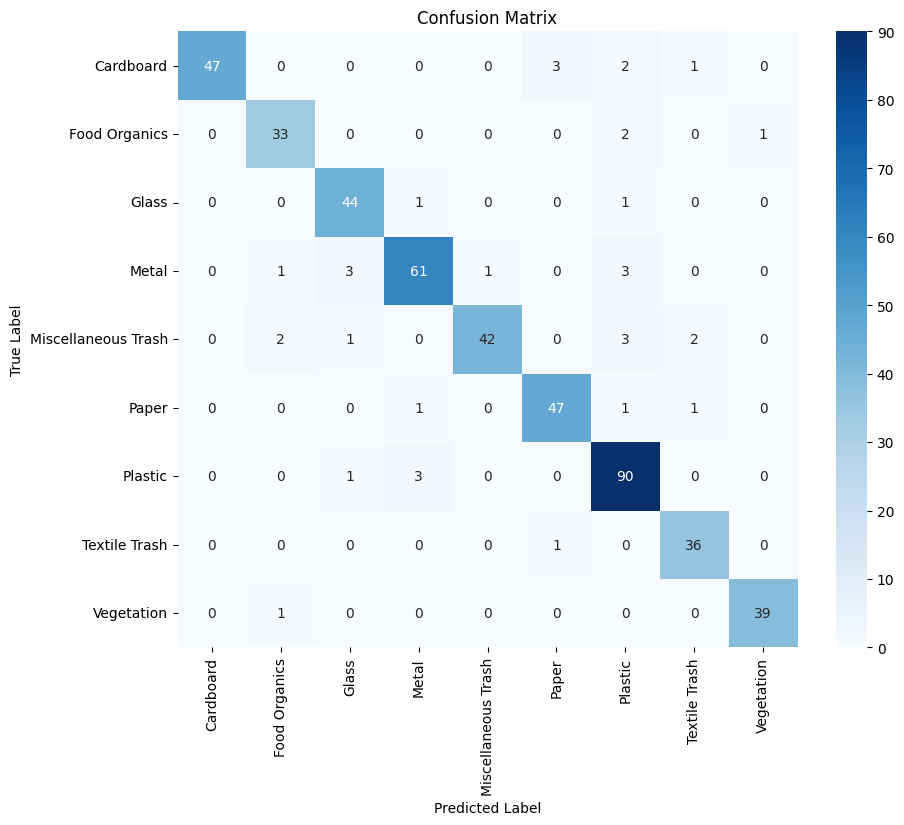

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

preds_list = []
labels_list = []

model.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim = 1)
        
        preds_list.extend(preds.cpu().numpy())
        labels_list.extend(labels.cpu().numpy())

cm = confusion_matrix(labels_list, preds_list)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [14]:
model_path = "/kaggle/working/best_model.pth"
torch.save(model.state_dict(), model_path) 

model.load_state_dict(torch.load("/kaggle/working/best_model.pth", map_location="cpu"))
model.eval()

scripted_model = torch.jit.script(model)
scripted_model.save("/kaggle/working/model_scripted.pt")

<ipython-input-14-f7f3724b03de>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/working/best_model.pth", map_location="cpu"))


In [18]:
%%writefile /kaggle/working/app/streamlit_app.py

import streamlit as st
import torch
from torchvision import transforms
from PIL import Image

model = torch.jit.load("/kaggle/working/model_scripted.pt", map_location="cpu")
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

labels = ["Cardboard", "Food Organics", "Glass", "Metal", "Miscellaneous Trash", "Paper", "Plastic", "Textile Trash", "Vegetation"]

st.title("♻️ Waste Classification Model")
st.write("Upload an image to classify it into one of the 9 waste categories.")
uploaded_file = st.file_uploader("Choose an image...", type=["jpg", "png", "jpeg"])

if uploaded_file is not None:
    # Open and display the image
    image = Image.open(uploaded_file)
    st.image(image, caption="Uploaded Image", use_column_width=True)

    # Preprocess the image
    image_tensor = transform(image).unsqueeze(0)

    # Make prediction
    with torch.no_grad():
        output = model(image_tensor)
        prediction = output.argmax(dim=1).item()

    # Display prediction
    st.success(f"Predicted Category: **{labels[prediction]}**")

Writing /kaggle/working/app/streamlit_app.py
